<h1 style="text-align:center">Ch 4.3. QDA<h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numba import jit

 ## 1. Fit a quadratic model

### 1-1. Sample estimates (Gaussian Parameters)

In [2]:
def prior_hat(N, N_k):
    return N_k/N

In [3]:
def mu_hat(x, N_k):
    return np.sum(x, axis=0)/N_k 

In [4]:
def sig(x, mu_hat):
    r,c = x.shape 
    S = (x[0,:]-mu_hat).T*(x[0,:]-mu_hat)
    for i in range(1,r):
        S += (x[i,:]-mu_hat).T*(x[i,:]-mu_hat)
    return S/(r-1)

### 1-2. Discrimination Function

$$\delta_k(x) = -\frac{1}{2}\log |\Sigma_k| - \frac{1}{2}(x - \mu_k)^T \Sigma_k^{-1}(x - \mu_k) + \log \pi_k$$

In [5]:
def Delta(x, sig_hat, mu_hat, prior_hat):
    return -1/2*np.log(np.linalg.det(sig_hat)) - 1/2 * (x - mu_hat) * np.linalg.inv(sig_hat) * (x - mu_hat).T + np.log(prior_hat)  # x가 행렬꼴일 때여서 x의 transpose 대신 X, (N*1) 크기의 행렬이 됨

In [6]:
def Deltas_QDA(x, sig_hats, mu_hats, prior_hats):
    return [Delta(x, sig_hats, mu, prior) for (sig_hats, mu, prior) in zip(sig_hats, mu_hats, prior_hats)]

In [7]:
def find_G_hat(deltas):
    return np.argmax(deltas, axis=0)[0,0]

## 2. Implementation for Example
- $N = 100$
- $K = 3$
- $p=2$

::LDA assumption::
 The classes have a common covariance matrix

In [8]:
# Input variables
feature = 2
N=100
K=3

np.random.seed(15)

x1_x = np.matrix(np.random.normal(loc=0.8,scale=0.2,size=(40,1))) # loc=mean, scale=variation
x1_y = np.matrix(np.random.normal(loc=1,scale=0.4,size=(40,1)))
x1 = np.column_stack([x1_x, x1_y])

x2_x = np.matrix(np.random.normal(1.5,0.1, size=(30,1)))
x2_y = np.matrix(np.random.normal(3,0.3, size=(30,1)))
x2 = np.column_stack([x2_x, x2_y])

x3_x = np.matrix(np.random.normal(2.2,0.1, size=(30,1)))
x3_y = np.matrix(np.random.normal(0.8, 0.1, size=(30,1)))
x3 = np.column_stack([x3_x, x3_y])

In [9]:
# data size of subsets
n1,_ = x1.shape 
n2,_ = x2.shape
n3,_ = x3.shape

### 2-1. Estimated Gaussian parameters

In [10]:
xs = [x1, x2, x3]
ns = [x.shape[0] for x in xs]
prior_hats = [prior_hat(N, n) for n in ns] # estimated prior probabilities 
mu_hats_trsp = [mu_hat(x,n) for (x,n) in zip(xs, ns)] # estimated means 
sig_hats = [sig(x, mu) for (x, mu) in zip(xs, mu_hats_trsp)]  # sigs = sig1 + sig2 + ... + sigK

### 2-2. New data

In [11]:
new_x = np.matrix("1.7 1.7")
new_x2 = np.matrix("0 1.5")

In [12]:
new_x.shape

(1, 2)

In [13]:
Deltas_QDA(new_x, sig_hats, mu_hats_trsp, prior_hats)

[matrix([[-9.70079349]]), matrix([[-10.44488872]]), matrix([[-53.84053332]])]

In [14]:
G = find_G_hat(Deltas_QDA(new_x, sig_hats, mu_hats_trsp, prior_hats))
print(G)
if G == 0:
    print("Cat")
elif G == 1:
    print("Dog")
else:
    print("Rabbit")

0
Cat


In [15]:
G2 = find_G_hat(Deltas_QDA(new_x2, sig_hats, mu_hats_trsp, prior_hats))
print(G2)
if G2 == 0:
    print("Cat")
elif G2 == 1:
    print("Dog")
else:
    print("Rabbit")

0
Cat


## 3. Plotting

In [16]:
x11 = np.asarray(x1[:,0]).ravel()
x12 = np.asarray(x1[:,1]).ravel()
x21 = np.asarray(x2[:,0]).ravel()
x22 = np.asarray(x2[:,1]).ravel()
x31 = np.asarray(x3[:,0]).ravel()
x32 = np.asarray(x3[:,1]).ravel()

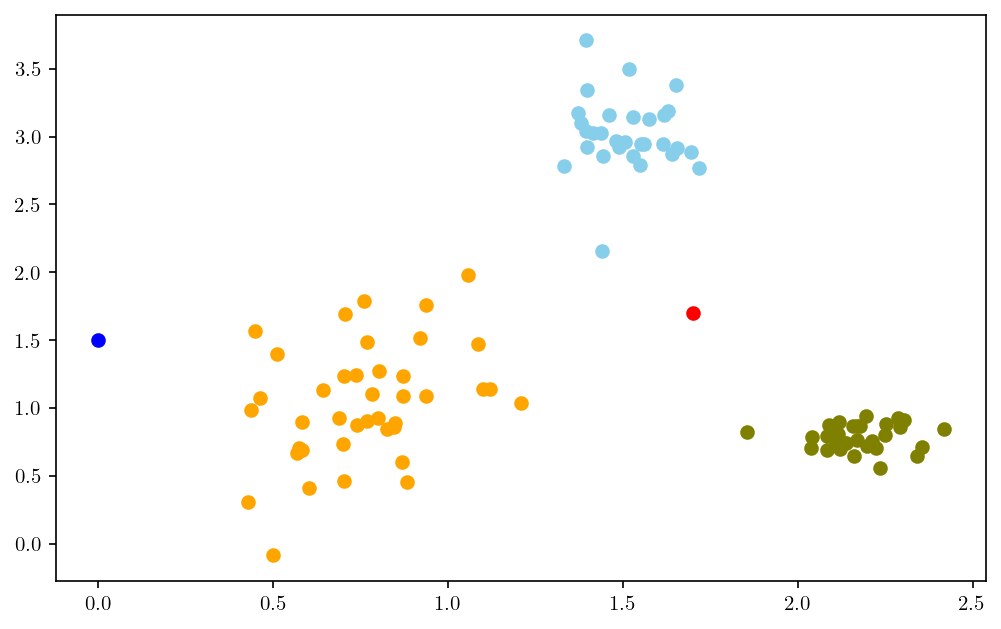

In [17]:
# Use latex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Prepare Plot
plt.figure(figsize=(8,5), dpi=150)

plt.scatter(x11, x12, color="orange")
plt.scatter(x21, x22, color="skyblue")
plt.scatter(x31, x32, color="olive")
plt.scatter(new_x[0,0],new_x[0,1], color="red")
plt.scatter(new_x2[0,0],new_x2[0,1], color="blue")

### 3-1. Decision Boundaries

In [18]:
xs = np.arange(0.1, 2.6, 0.01)
ys = np.arange(-2, 5, 0.01)

In [19]:
def find_boundary(xs, ys, sig_hats, mu_hats_trsp, prior_hats):
    B12 = []
    B23 = []
    B31 = []
    for x in xs:
#         b12_xstack = []
#         b12_ystack = []
        for y in ys:
            X_temp = np.matrix([x,y])
            Deltas_temp = Deltas_QDA(X_temp, sig_hats, mu_hats_trsp, prior_hats)
            if abs((Deltas_temp[0]- Deltas_temp[1])[0,0]) < 0.01:
#                 b12_xstack.append(x)
#                 b12_ystack.append(y)
                B12.append([x, y])
            elif abs((Deltas_temp[1]- Deltas_temp[2])[0,0]) < 0.01:
                B23.append([x, y])
            elif abs((Deltas_temp[2]- Deltas_temp[0])[0,0]) < 2:
                B31.append([x, y])
#         if len(b12_ystack) > 0:
#             i = np.argmax(b12_ystack)
#             B12.append([b12_xstack[i], b12_ystack[i]])
        
    return (B12, B23, B31)

In [20]:
B12, B23, B31 = find_boundary(xs, ys, sig_hats, mu_hats_trsp, prior_hats)

In [21]:
B12 = np.matrix(B12)
B23 = np.matrix(B23)
B31 = np.matrix(B31)

In [22]:
B31

matrix([[1.57, 0.7 ],
        [1.57, 0.71],
        [1.57, 0.72],
        ...,
        [2.59, 1.64],
        [2.59, 1.65],
        [2.59, 1.66]])

In [23]:
B12_x = np.asarray(B12[:,0]).ravel()
B12_y = np.asarray(B12[:,1]).ravel()
B23_x = np.asarray(B23[:,0]).ravel()
B23_y = np.asarray(B23[:,1]).ravel()
B31_x = np.asarray(B31[:,0]).ravel()
B31_y = np.asarray(B31[:,1]).ravel()

(-2.0, 5.0)

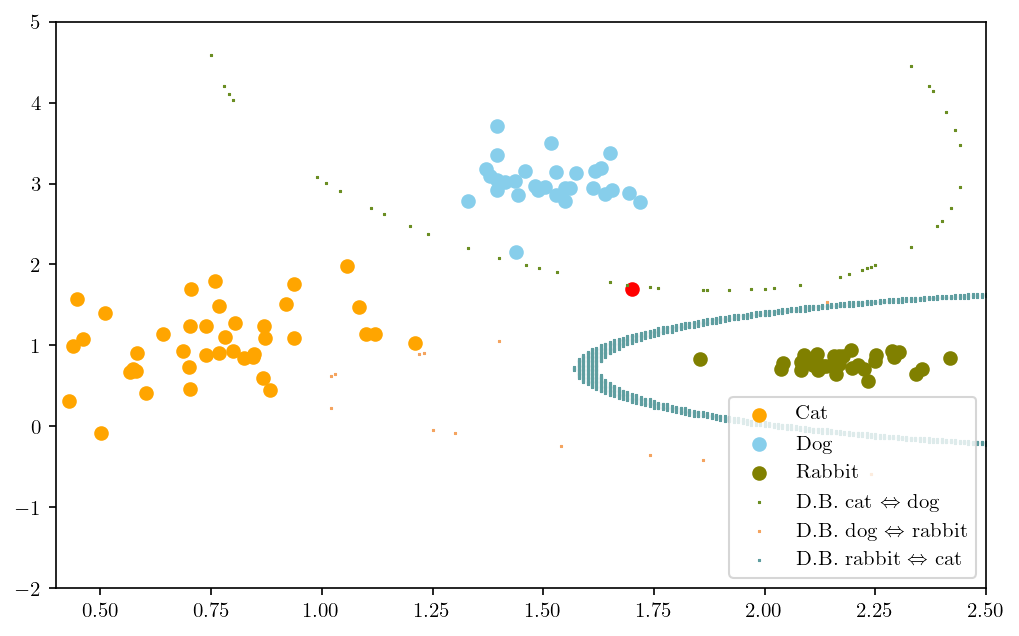

In [24]:
# Prepare Plot
plt.figure(figsize=(8,5), dpi=150)

plt.scatter(x11, x12, color="orange", label="Cat")
plt.scatter(x21, x22, color="skyblue", label="Dog")
plt.scatter(x31, x32, color="olive", label="Rabbit")
plt.scatter(new_x[0,0],new_x[0,1], color="red")

plt.scatter(B12_x, B12_y, s=0.5, color="olivedrab", marker='+', label=r"D.B. cat $\Leftrightarrow$ dog")
plt.scatter(B23_x, B23_y, s=0.5, color="sandybrown", marker='+', label=r"D.B. dog $\Leftrightarrow$ rabbit")
plt.scatter(B31_x, B31_y, s=0.5, color="cadetblue", marker='+', label="D.B. rabbit $\Leftrightarrow$ cat")

plt.legend(loc="lower right")
plt.xlim([0.4, 2.5])
plt.ylim([-2,5])

In [25]:
[np.linalg.inv(sig) for sig in sig_hats]

[matrix([[29.15567409, -4.708614  ],
         [-4.708614  ,  6.07359469]]),
 matrix([[88.37221508,  2.77120839],
         [ 2.77120839, 13.68773585]]),
 matrix([[ 79.90959483,  -3.45532158],
         [ -3.45532158, 111.69681634]])]